## Finding the hubble constant.
Using public data provided by the supernova galactic survey. This gives a list of supernovae along with their observed distances (with uncertainties) and their redshifts. These data are obtained through galactic observations of supernovae, with the line shifts indicating their respective redshift.
https://supernova.lbl.gov/Union/

**About the Data**

When loading the data, we need to know that the data is stored in terms of the distance modulus,

$$
\begin{equation}
d=10^{\frac{\mu}{5} + 1}
\end{equation}
$$

Furthermore, the uncertainty $\sigma_{\mu}$ is also given in terms of the distance modulus. Given our relationship between the distance modulus and the distance, we can get the uncertainty in distance:

$$
\begin{align}
\sigma_{d} & = \frac{d}{d\mu}d(\mu) \cdot \sigma_{\mu} \\
           & = \frac{\log(10)}{5} 10^{\frac{\mu}{5} + 1}   \sigma_{\mu}
\end{align}
$$

In [29]:
import math
import matplotlib.pyplot as plt
import numpy as np
import csv
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

Define the convertors and load data only upto specific range (iZMax)

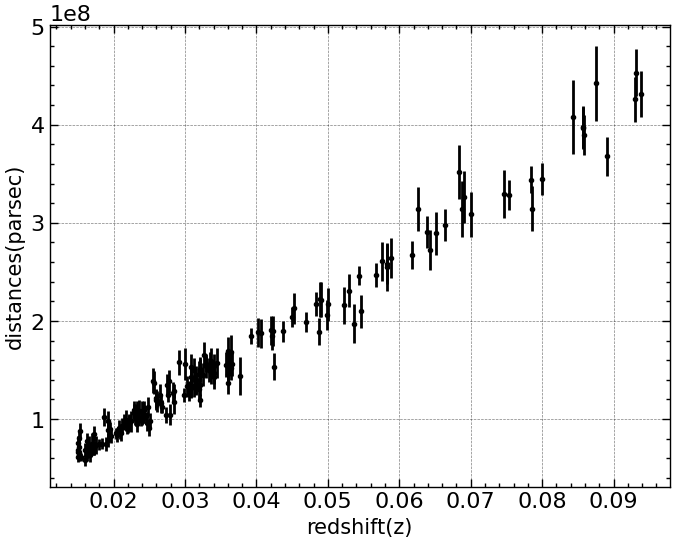

In [30]:
#Table stores name, redshift, distance modulus, distance modulus error
label= 'sn_z_mu_dmu_plow_union2.1.txt'

#Convert from distance modulus to distance
def distanceconv(iMu):
    power=iMu/5+1
    return 10**power

# and the same for uncertainty in distance modulus to uncertainty in distance
def distanceconverr(iMu,iMuErr):
    power=iMu/5+1
    const=math.log(10)/5.
    return const*(10**power)*iMuErr

#Now let's zoom in on the small redshift data. Original data is upto 1.4
def load(iLabel,iZMax):
    # loads data from file iLabel with redshift below iZMax:
    redshift=[]
    distance=[]
    distance_err=[]
    with open(label,'r') as csvfile:
        plots = csv.reader(csvfile, delimiter='\t')
        for row in plots:
            if float(row[1]) > iZMax:
                continue
            redshift.append(float(row[1]))
            distance.append(distanceconv(float(row[2])))
            distance_err.append(distanceconverr(float(row[2]),float(row[3])))
    return np.array(redshift), np.array(distance), np.array(distance_err)

redshift,distance,distance_err = load(label,0.1)
plt.xlabel('redshift(z)', fontsize=15) #Label x
plt.ylabel('distances(parsec)', fontsize=15)#Label y
plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
plt.show()

## Linear Regression
The data above has what looks like a linear trend. So, we try fitting a linear model; that is, something of form

$$
\begin{equation}
y = Ax + b
\end{equation}
$$
Here, the best fit corresponds to the vale of A given as, 
$$
\begin{equation}
A = \frac{\rm{COV(x,y)}}{\rm{VAR(x)}}
\end{equation}
$$
where,
$$
\begin{align} 
\rm{VAR(x)}   & = \frac{1}{N}\sum_{i=1}^{N} \left(x_{i}-\bar{x}\right)^2 \\
\rm{COV(x,y)} & = \frac{1}{N}\sum_{i=1}^{N} \left(x_{i} - \bar{x} \right) \left(y_{i}-\bar{y}\right) \\
\end{align}
$$
And B is given 
$$
\begin{equation}
b = \bar{y} - A\bar{x}  
\end{equation}
$$

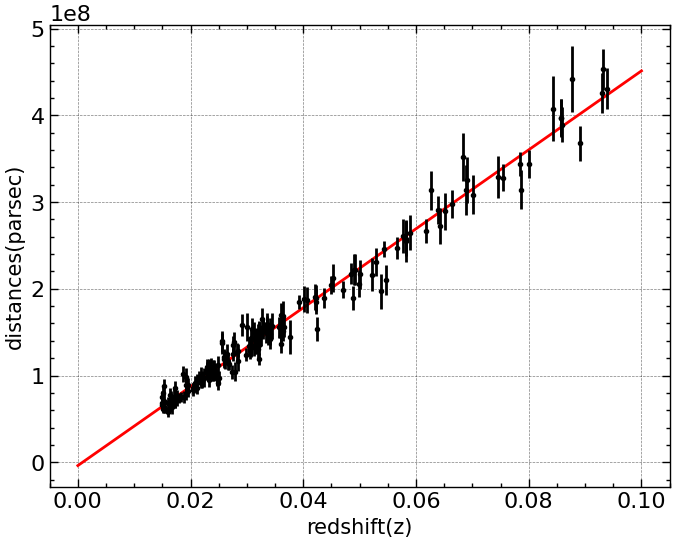

Hubbles Constant: 65.87381819553848 intercept -3931446.778206587


In [31]:
def variance(isamples):
    mean=isamples.mean()
    n=len(isamples)
    tot=0
    for pVal in isamples:
        tot+=(pVal-mean)**2
    return tot/n

def covariance(ixs,iys):
    meanx=ixs.mean()
    meany=iys.mean()
    n=len(ixs)
    tot=0
    for i0 in range(len(ixs)):
        tot+=(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/n

def linear(ix,ia,ib):
    return ia*ix+ib

def regress(redshift,distance):
    var=variance(redshift)
    cov=covariance(redshift,distance)
    A=cov/var
    b=distance.mean()-A*redshift.mean()
    return A,b

def plotAll(redshift,distance,distance_err,A,b):
    xvals = np.linspace(0,0.1,100)
    yvals = []
    for pX in xvals:
        yvals.append(linear(pX,A,b))

    #Plot the line
    plt.plot(xvals,yvals, 'r')
    plt.errorbar(redshift,distance,yerr=distance_err,marker='.',linestyle = 'None', color = 'black')
    plt.xlabel('redshift(z)', fontsize=15) #Label x
    plt.ylabel('distances(parsec)', fontsize=15)#Label y
    plt.show()
    #Print it out
    print("Hubbles Constant:",1e6*3e5/A,"intercept",b)#Note 1e6 is from pc to Mpc and 3e5 is c in km/s

A,b = regress(redshift,distance)
plotAll(redshift,distance,distance_err,A,b)

## Weighted linear regression

Each measurement of some variable $y$ carries an uncertainty $\sigma_{y}$. How the uncertainty is actually computed depends on the experiment. However, the uncertainty is **supposed** to correspond to the RMS of the measured value. More precisely, the variance  should approach $\sigma^{2}_{y}$ as we increase $N$.

We can define a metric to minimize that accounts for the fact that different measurements can have larger or smaller uncertainties. 

$$
\begin{align} 
Q & = \sum_{i=1}^{N}\frac{\left(y_{i}-\hat{y}_{i}\right)^2}{\sigma^{2}_{y_{i}}} \\
Q & = \sum_{i=1}^{N}\frac{\left(y_{i}-Ax_{i}-b\right)^2}{\sigma^{2}_{y_{i}}} \\
\end{align}
$$

What does this do? For any $y_i$ that has a large uncertainty, the corresponding contribution to the metric $Q$ is scaled down, since we trust it less. We can now follow the same procedure as before and minimize this adjusted metric with respect to $A$ and $b$.

$$
\begin{align} 
A  & = \frac{\frac{1}{N}\sum_{i=1}^{N} \frac{1}{\sigma_{i}^2}\left(x_{i} - \bar{x}_{w} \right) \left(y_{i}-\bar{y}_{w}\right)}      
              {\frac{1}{N}\sum_{i=1}^{N} \frac{1}{\sigma_{i}^2}\left(x_{i}-\bar{x}_{w}\right)^2}\\
b  & = \bar{y}_{w} - A\bar{x}_{w}      
\end{align}   
$$

where,
$$\bar{y}_{w} = \frac{\sum_{i=1}^{N} \frac{y_{i}}{\sigma_{i}^2} }{\sum_{i=1}^{N} \frac{1}{\sigma_{i}^2} }$$

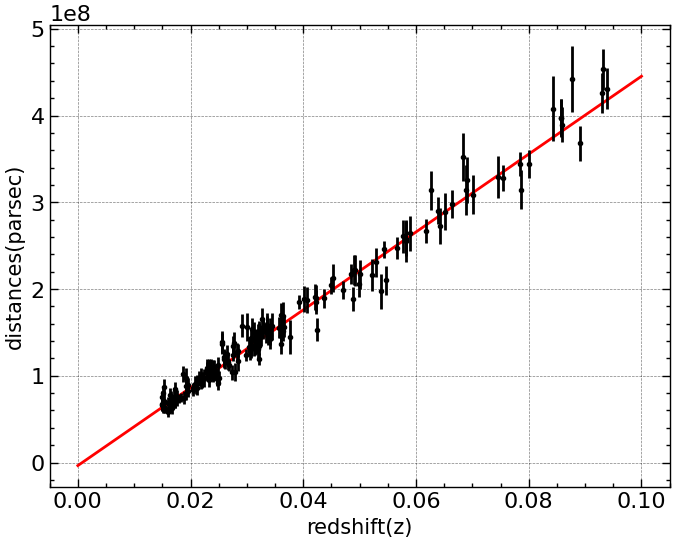

Hubbles Constant: 66.84173202572255 intercept -3501821.361192003


In [32]:
weights=[]
for err in distance_err:
    weights.append(1./err**2)
    
weights = np.array(weights)

#Now let's do it with weights
def variance_w(isamples,iweights):
    mean=np.average(isamples,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(isamples)):
        tot+=iweights[i0]*(isamples[i0]-mean)**2
    return tot/sumw

def covariance_w(ixs,iys,iweights):
    meanx=np.average(ixs,weights=iweights)
    meany=np.average(iys,weights=iweights)
    sumw=np.sum(iweights)
    tot=0
    for i0 in range(len(ixs)):
        tot+=iweights[i0]*(ixs[i0]-meanx)*(iys[i0]-meany)
    return tot/sumw

def regress_w(redshift,weights,distance):
    varw=variance_w(redshift,weights)
    covw=covariance_w(redshift,distance,weights)
    Aw=covw/varw
    bw=np.average(distance,weights=weights)-Aw*np.average(redshift,weights=weights)
    return Aw,bw

Aw,bw=regress_w(redshift,weights,distance)
plotAll(redshift,distance,distance_err,Aw,bw)

### Let's do the same thing using libraries

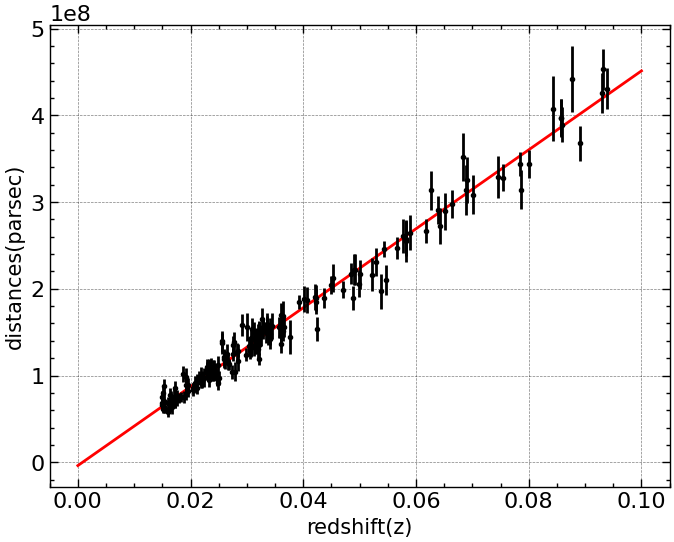

Hubbles Constant: 65.8738181955385 intercept -3931446.7782065272
UnWeighted Fit: Hubbles Constant: 65.8738181955385 intercept -3931446.7782065272


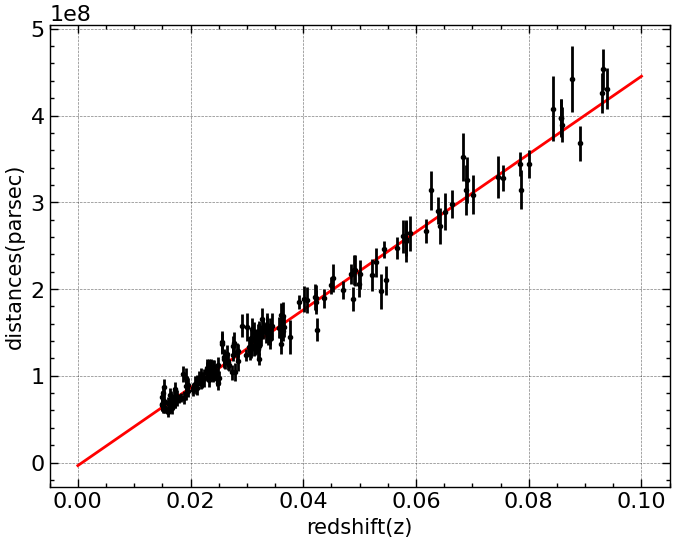

Hubbles Constant: [66.84173203] intercept -3501821.3611919284
Weighted Fit: Hubbles Constant: [66.84173203] intercept -3501821.3611919284


(array([4.48821404e+09]),
 -3931446.7782065272,
 0.9897556538933284,
 3.465572231168363e-148,
 49945845.57672982)

In [33]:
from scipy import stats

# UnWeighted Fit with scipy
slope, intercept, r_value, p_value, std_err = stats.linregress(redshift,distance)
plotAll(redshift,distance,distance_err,slope,intercept)
print("UnWeighted Fit:","Hubbles Constant:",1e6*3e5/slope,"intercept",intercept)

# Weighted version; we use scikit-learn, a package dedicated to fitting
from sklearn.linear_model import LinearRegression
model = LinearRegression()
redshifthack = np.reshape(redshift,(len(redshift),1)) #line to get the fit code to work
model.fit(redshifthack,distance,weights)
slope = model.coef_
const = model.intercept_
plotAll(redshift,distance,distance_err,slope,const)
print("Weighted Fit:","Hubbles Constant:",1e6*3e5/slope,"intercept",const)
slope, intercept, r_value, p_value, std_err